# Введение - описание проекта

Сервис Repetit.ru передает контакты клиента (ученика) репетитору. Если репетитор начинает заниматься с учеником, то он должен платить сервису комиссию от каждого занятия. Но в реальности так происходит не всегда. Иногда, это из-за того, что репетитор звонит по телефону и ему просто не отвечают. Некоторые репетиторы плохо договариваются о занятиях или обманывают. Сервис теряет деньги каждый раз, когда отдаёт заявку неэффективному репетитору. Заказчику нужно как можно раньше понять, что репетитор недобросовестный или мошенник, чтобы отключить его от сервиса и отдавать заявки ответственным репетиторам.\
\
Сейчас эта задача решается ручным просмотром сотрудниками или никак.\
\
**Задача**\
Разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий будет классифицировать репетиторов на платящих и неэффективных. Оценка качества модели будет производиться с использованием метрики F1.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from catboost import CatBoostRegressor, CatBoostClassifier
from lightgbm import LGBMClassifier
from datetime import datetime
from datetime import date


Настраиваю опции отображения таблиц

In [2]:
pd.set_option('max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Открываю файлы с данными

In [3]:
df_lesson_course = pd.read_feather(r'C:\Users\2011\Desktop\Data Science\2024-03-Repetit.ru-репетиторы-мошенники/lesson_course.feather')
df_lesson_course.info()
display (df_lesson_course.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB


,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
0,240884,427831.00,133738,718009.00,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000
1,242243,429075.00,106838,720876.00,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000
2,242364,429089.00,14700,720912.00,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940
3,242476,428940.00,138783,721219.00,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000
4,242942,424704.00,3476,720891.00,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000


In [4]:
df_lessons = pd.read_feather(r'C:\Users\2011\Desktop\Data Science\2024-03-Repetit.ru-репетиторы-мошенники/lessons.feather')
df_lessons.info()
display (df_lessons.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   id                1191127 non-null  int32   
 1   lesson_course_id  1191127 non-null  int32   
 2   lesson_date       1191127 non-null  category
 3   time_from         1191127 non-null  category
 4   time_to           1191127 non-null  category
 5   home_task         4969 non-null     category
 6   is_regular        1191127 non-null  int8    
 7   amount_to_pay     593376 non-null   float64 
 8   amount_paid       8143 non-null     float64 
dtypes: category(4), float64(2), int32(2), int8(1)
memory usage: 37.9 MB


,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,135797,347,2023-04-14 00:00:00.000,12:45:00,13:50:00,NaN,1,NaN,NaN
1,283596,185756,2022-11-15 00:00:00.000,20:30:00,21:30:00,NaN,0,NaN,NaN
2,322184,184189,2022-12-15 00:00:00.000,16:00:00,17:30:00,NaN,0,NaN,NaN
3,371621,213849,2023-02-13 00:00:00.000,19:30:00,20:30:00,NaN,0,NaN,NaN
4,375586,196475,2023-02-16 00:00:00.000,10:00:00,11:00:00,NaN,0,NaN,NaN


In [5]:
df_orders = pd.read_feather(r'C:\Users\2011\Desktop\Data Science\2024-03-Repetit.ru-репетиторы-мошенники/orders.feather')
df_orders.info()
display (df_orders.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.00,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.00,675960,7.00,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.00,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к заявке № 2294000"" (Алешина Марина)",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.00,675960,7.00,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.00,Разделы: начертательная геометрия.\nКатегория ученика: студентка 1 курса.\nЦель занятий: помощь по программе.,800,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype). Время МСК.\nПредполагаемое число занятий в неделю: 1, будни и суббота после 17, воскресенье в течение дня.",2022-11-01 10:37:02.567,143480.00,16,None,NaN,0,7,None,NaN,14.00,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.00,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.00,Разделы: школьный курс.\nКатегория ученика: школьник 9 класса.\nЦель занятий: помощь по школьной программе.,700,60,None,NaN,"Место проведения занятий: дистанционно (например, Skype).\nПредполагаемое число занятий в неделю: 1-2, вторник, четверг с 17, суббота с 14.\nОпыт репетитора: от 5 лет.\nВозраст репетитора: от 20 лет до 90 лет.\nПол репетитора: не имеет значения.\nСтатус репетитора: школьный преподаватель.",2022-11-01 00:08:47.437,236392.00,16,None,NaN,0,10,None,47749.00,10.00,3,0,3,5,0,4,0,20,90,0,0,14,2293804.00,1024340,17.00,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.00,None,0,60,None,122.00,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.00,NaN,None,None,1


In [6]:
df_teacher_prices = pd.read_feather(r'C:\Users\2011\Desktop\Data Science\2024-03-Repetit.ru-репетиторы-мошенники/teacher_prices.feather')
df_teacher_prices.info()
display (df_teacher_prices.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB


,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20 19:47:18.587,300.00,2,1200,1200,1200
1,2008-01-22 00:33:39.660,125.00,13,0,0,3000
2,2008-01-22 00:33:39.660,125.00,14,0,0,3000
3,2008-01-22 00:37:01.963,91.00,8,2000,0,0
4,2008-02-08 21:27:19.177,372.00,33,400,400,400


In [7]:
df_teachers = pd.read_feather(r'C:\Users\2011\Desktop\Data Science\2024-03-Repetit.ru-репетиторы-мошенники/teachers.feather')
df_teachers.info()
display (df_teachers.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB


,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470.00,1284.22,469.00,0.67,78.17,602300.00,0
1,153845,1111.00,884.09,1082.00,0.36,77.29,956580.00,0
2,42869,505.00,2500.00,184.00,0.14,61.33,460000.00,0
3,127280,442.00,1879.34,363.00,0.15,60.50,682200.00,0
4,283905,694.00,1252.43,534.00,0.26,59.33,668800.00,0


In [8]:
df_teachers_info = pd.read_feather(r'C:\Users\2011\Desktop\Data Science\2024-03-Repetit.ru-репетиторы-мошенники/teachers_info.feather')
df_teachers_info.info()
display (df_teachers_info.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           307972 non-null  int64  
 14  revi

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,33,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,0,60,1000,1,2022-10-24 16:48:38.410,1.00,0,1,1,0,6
1,46,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,0,60,500,0,None,1.00,0,1,3,1,0
2,51,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,0,60,1500,0,2022-09-26 09:43:56.123,1.00,0,1,2,1,0
3,52,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,0,60,1000,1,2020-04-03 15:53:50.867,0.00,0,1,2,1,2
4,54,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,0,45,400,0,None,1.00,0,1,3,1,0


# Объединяю таблицы

### Объединяю таблицы teachers & teachers_info

In [9]:
df_merge_teachers = df_teachers_info.merge(df_teachers, on='id', how='right')

In [10]:
df_merge_teachers.info()
display (df_merge_teachers.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1656 entries, 0 to 1655
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   reg_date                  1602 non-null   object 
 2   birth_date                1602 non-null   object 
 3   teaching_start_date       1602 non-null   object 
 4   is_email_confirmed        1602 non-null   float64
 5   lesson_duration           1602 non-null   float64
 6   lesson_cost               1602 non-null   float64
 7   is_display                1602 non-null   float64
 8   last_visited              1249 non-null   object 
 9   is_pupils_needed          26 non-null     float64
 10  is_cell_phone_confirmed   1602 non-null   float64
 11  area_id                   1602 non-null   float64
 12  sex                       1602 non-null   float64
 13  orders_allowed            1602 non-null   float64
 14  review_n

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.00,60.00,800.00,1.00,2022-10-21 16:44:49.877,NaN,0.00,2.00,1.00,1.00,10.00,470.00,1284.22,469.00,0.67,78.17,602300.00,0
1,153845,2018-10-19 20:23:24.157,1968-03-10 00:00:00.000,1985-09-01 00:00:00.000,0.00,60.00,600.00,1.00,2022-10-22 16:16:44.800,NaN,0.00,13.00,2.00,1.00,26.00,1111.00,884.09,1082.00,0.36,77.29,956580.00,0
2,42869,2012-09-20 20:42:52.000,1965-04-20 00:00:00.000,2002-09-01 00:00:00.000,0.00,60.00,2500.00,1.00,2022-10-22 21:21:47.523,NaN,0.00,2.00,2.00,1.00,64.00,505.00,2500.00,184.00,0.14,61.33,460000.00,0
3,127280,2017-09-06 16:51:20.000,1986-05-07 00:00:00.000,2005-09-01 00:00:00.000,0.00,60.00,1500.00,1.00,2022-03-17 22:50:23.267,NaN,0.00,1.00,2.00,1.00,10.00,442.00,1879.34,363.00,0.15,60.50,682200.00,0
4,283905,2023-01-18 13:16:08.137,1973-09-14 00:00:00.000,1992-09-01 00:00:00.000,0.00,45.00,1178.00,1.00,None,NaN,0.00,116.00,2.00,1.00,1.00,694.00,1252.43,534.00,0.26,59.33,668800.00,0


Переименовываю столбец id в teacher_id, чтобы было удобнее объединить со следующей таблицей и чтобы не запутаться в этих id

In [11]:
df_merge_teachers = df_merge_teachers.rename(columns={'id':'teacher_id'})

### Присоединяю к получившейся таблице df_merge_teachers таблицу teacher_prices

Таблицу df_teacher_prices группирую по teacher_id

In [12]:
df_group_teacher_prices = df_teacher_prices.groupby(['teacher_id'], as_index=False).agg({'subject_id':'unique', 'price':'mean', 'price_external':'mean', 'price_remote':'mean'})

In [13]:
df_group_teacher_prices.info()
display(df_group_teacher_prices.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271396 entries, 0 to 271395
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   teacher_id      271396 non-null  float64
 1   subject_id      271396 non-null  object 
 2   price           271396 non-null  float64
 3   price_external  271396 non-null  float64
 4   price_remote    271396 non-null  float64
dtypes: float64(4), object(1)
memory usage: 12.4+ MB


,teacher_id,subject_id,price,price_external,price_remote
0,33.00,[18],500.00,0.00,1000.00
1,46.00,[6],500.00,500.00,500.00
2,51.00,"[1, 21, 33]",0.00,0.00,1933.33
3,52.00,"[4, 3]",0.00,1000.00,1000.00
4,54.00,[4],400.00,400.00,400.00


Получившуюся сгруппированную таблицу присоединяю к df_merge_teachers

In [14]:
df_merge_teachers_prices = df_merge_teachers.merge(df_group_teacher_prices, on='teacher_id', how='left')

In [15]:
df_merge_teachers_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1656 entries, 0 to 1655
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   teacher_id                1656 non-null   int64  
 1   reg_date                  1602 non-null   object 
 2   birth_date                1602 non-null   object 
 3   teaching_start_date       1602 non-null   object 
 4   is_email_confirmed        1602 non-null   float64
 5   lesson_duration           1602 non-null   float64
 6   lesson_cost               1602 non-null   float64
 7   is_display                1602 non-null   float64
 8   last_visited              1249 non-null   object 
 9   is_pupils_needed          26 non-null     float64
 10  is_cell_phone_confirmed   1602 non-null   float64
 11  area_id                   1602 non-null   float64
 12  sex                       1602 non-null   float64
 13  orders_allowed            1602 non-null   float64
 14  review_n

### Присоединяю к таблице lesson_course таблицу lessons

Переименовываю в таблице lessons стобцец lesson_course_id на client_id, чтобы было удобнее объединять таблицы и не путаться с разными названиями столбцов

In [16]:
df_lessons = df_lessons.rename(columns={'lesson_course_id':'client_id'})

In [17]:
df_merge_lessons = df_lesson_course.merge(df_lessons, on='client_id', how='left')

In [18]:
df_merge_lessons.info()
display(df_merge_lessons.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1883234 entries, 0 to 1883233
Data columns (total 18 columns):
 #   Column             Dtype   
---  ------             -----   
 0   id_x               int64   
 1   client_id          float64 
 2   teacher_id         int64   
 3   order_id           float64 
 4   lesson_place       int64   
 5   lesson_price       int64   
 6   is_active          int64   
 7   lesson_duration    int64   
 8   date_updated       object  
 9   suspend_till_date  object  
 10  id_y               float64 
 11  lesson_date        category
 12  time_from          category
 13  time_to            category
 14  home_task          category
 15  is_regular         float64 
 16  amount_to_pay      float64 
 17  amount_paid        float64 
dtypes: category(4), float64(6), int64(6), object(2)
memory usage: 230.3+ MB


,id_x,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date,id_y,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,240884,427831.00,133738,718009.00,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,242243,429075.00,106838,720876.00,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,242364,429089.00,14700,720912.00,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,242476,428940.00,138783,721219.00,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,242942,424704.00,3476,720891.00,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удаляю лишние столбцы

In [19]:
df_merge_lessons = df_merge_lessons.drop(['id_x', 'id_y'], axis=1)

### Присоединяю к таблице df_merge_lessons таблицу orders

Переименовываю столбец id в order_id, чтобы объединить таблицы было удобнее

In [20]:
df_orders = df_orders.rename(columns={'id':'order_id'})

Выбираю из таблицы df_orders несколько столбцов, которые, на мой взгляд, помогут решить задачу. 

In [21]:
df_orders_few = df_orders [['order_id', 'subject_id', 'lesson_price', 'status_id', 'planned_lesson_number', \
                            'first_lesson_date', 'lessons_per_week', 'original_order_id', 'client_id']]

Переименовываю столбец lesson_price в lesson_price_order

In [22]:
df_orders_few = df_orders_few.rename(columns={'lesson_price':'lesson_price_order'})

In [23]:
#df_orders_few.info()
display(df_orders_few.head(5))

,order_id,subject_id,lesson_price_order,status_id,planned_lesson_number,first_lesson_date,lessons_per_week,original_order_id,client_id
0,2294054,1.00,0,16,0,None,0,2294000.00,675960
1,2294055,1.00,0,7,0,None,0,2294000.00,675960
2,2294056,21.00,800,16,7,None,2,NaN,1024439
3,2294057,8.00,700,16,10,None,3,2293804.00,1024340
4,2294058,8.00,0,16,0,None,0,NaN,1024440


In [24]:
df_merge_lessons_orders = df_merge_lessons.merge(df_orders_few, on='order_id', how='left')

In [25]:
df_merge_lessons_orders.info()
display (df_merge_lessons_orders.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885002 entries, 0 to 1885001
Data columns (total 24 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   client_id_x            float64 
 1   teacher_id             int64   
 2   order_id               float64 
 3   lesson_place           int64   
 4   lesson_price           int64   
 5   is_active              int64   
 6   lesson_duration        int64   
 7   date_updated           object  
 8   suspend_till_date      object  
 9   lesson_date            category
 10  time_from              category
 11  time_to                category
 12  home_task              category
 13  is_regular             float64 
 14  amount_to_pay          float64 
 15  amount_paid            float64 
 16  subject_id             float32 
 17  lesson_price_order     float64 
 18  status_id              float64 
 19  planned_lesson_number  float64 
 20  first_lesson_date      object  
 21  lessons_per_week       float64 

,client_id_x,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid,subject_id,lesson_price_order,status_id,planned_lesson_number,first_lesson_date,lessons_per_week,original_order_id,client_id_y
0,427831.00,133738,718009.00,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,429075.00,106838,720876.00,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,429089.00,14700,720912.00,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,428940.00,138783,721219.00,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,424704.00,3476,720891.00,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проверяю получившуюся таблицу на пропуски. У меня получились 2 дублирующих друг друга столбца - client_id_x и client_id_y. Вот только в client_id_y больше пропусков. Удаляю client_id_y и переименовываю client_id_x

In [26]:
display (df_merge_lessons_orders.isna().sum())

client_id_x                    1
teacher_id                     0
order_id                    8572
lesson_place                   0
lesson_price                   0
is_active                      0
lesson_duration                0
date_updated                   0
suspend_till_date              0
lesson_date               702918
time_from                 702918
time_to                   702918
home_task                1880286
is_regular                702918
amount_to_pay            1350608
amount_paid              1875996
subject_id                412669
lesson_price_order        412669
status_id                 412669
planned_lesson_number     412669
first_lesson_date        1527494
lessons_per_week          412669
original_order_id        1267884
client_id_y               412669
dtype: int64

Проверяю, что значения в столбцах client_id_x и client_id_y одинаковые 

In [27]:
display (df_merge_lessons_orders.query('client_id_x >1 and client_id_y >1')[['client_id_x', 'client_id_y']].head(5))

,client_id_x,client_id_y
230883,840304.00,840304.00
230884,840237.00,840237.00
230885,839109.00,839109.00
230886,839109.00,839109.00
230887,243239.00,243239.00


Все хорошо, спокойно удаляю client_id_y

In [28]:
df_merge_lessons_orders = df_merge_lessons_orders.drop(['client_id_y'], axis=1)

In [29]:
df_merge_lessons_orders = df_merge_lessons_orders.rename(columns={'client_id_x':'client_id'})

### Создаю столбец group_payd

У каждой заявки может быть несколько дублей, и любой из оплаченных дублей считается оплатой всей группы заявок. Поэтому, создаю столбец group_payd, который показывает, что одна из заявок группы была оплачена

Заполняю нулями пропуски в таблице df_orders в стобце original_order_id

In [30]:
df_merge_lessons_orders['original_order_id'] = df_merge_lessons_orders['original_order_id'].fillna(0) 

Если в таблице df_merge_lessons_orders в столбце original_order_id есть пропуск, то заполняю этот пропуск значением из столбца id

In [31]:
def order_id (row):
    #если в столбце пропущено значение original_order_id, то функция возвращает значение из стобца id
    order_id = row ['order_id']
    original_id = row ['original_order_id']
    if original_id == 0:
        return order_id
    else:
        return original_id

df_merge_lessons_orders['order_id_new'] = df_merge_lessons_orders.apply(order_id, axis=1)

In [32]:
display (df_merge_lessons_orders[['order_id_new', 'order_id', 'original_order_id']].head(15))

,order_id_new,order_id,original_order_id
0,718009.00,718009.00,0.00
1,720876.00,720876.00,0.00
2,720912.00,720912.00,0.00
3,721219.00,721219.00,0.00
4,720891.00,720891.00,0.00
5,721693.00,721693.00,0.00
6,NaN,NaN,0.00
7,723036.00,723036.00,0.00
8,NaN,NaN,0.00
9,724441.00,724441.00,0.00


Добавляю столбец, в котором указываю факт оплаты одного из дублей - 'group_payd' (1 - оплачено, 0 - не оплачено)

In [33]:
df_orders_group = df_merge_lessons_orders.groupby('original_order_id')['status_id'].transform(lambda x: x.isin([6, 13]).any()).astype(int)
df_merge_lessons_orders['group_payd'] = df_orders_group

### Группирую df_merge_lessons_orders по teacher_id

In [34]:
df_merge_lessons_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885002 entries, 0 to 1885001
Data columns (total 25 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   client_id              float64 
 1   teacher_id             int64   
 2   order_id               float64 
 3   lesson_place           int64   
 4   lesson_price           int64   
 5   is_active              int64   
 6   lesson_duration        int64   
 7   date_updated           object  
 8   suspend_till_date      object  
 9   lesson_date            category
 10  time_from              category
 11  time_to                category
 12  home_task              category
 13  is_regular             float64 
 14  amount_to_pay          float64 
 15  amount_paid            float64 
 16  subject_id             float32 
 17  lesson_price_order     float64 
 18  status_id              float64 
 19  planned_lesson_number  float64 
 20  first_lesson_date      object  
 21  lessons_per_week       float64 

In [35]:
df_merge_lessons_orders_group = df_merge_lessons_orders.groupby(['teacher_id'], as_index=False).agg({'client_id':'count', 'order_id':'count', 'is_active':'max',\
                                                                                                    'is_regular':'max',\
                                                                                                    'amount_to_pay':'mean', 'amount_paid':'mean', \
                                                                                                    'lesson_price_order':'mean', 'planned_lesson_number':'mean',\
                                                                                                    'lessons_per_week':'mean'})

Переименовываю столбцы, чтобы не запутаться

In [36]:
df_merge_lessons_orders_group = df_merge_lessons_orders_group.rename(columns={'client_id':'client_id_count', 'order_id':'order_id_count', 'amount_to_pay':'amount_to_pay_mean',\
                                                                             'amount_paid':'amount_paid_mean', \
                                                                            'lesson_price_order':'lesson_price_order_mean', 'planned_lesson_number':'planned_lesson_number_mean',\
                                                                             'lessons_per_week':'lessons_per_week_mean'})

In [37]:
display (df_merge_lessons_orders_group.head(15))
df_merge_lessons_orders_group.info()

,teacher_id,client_id_count,order_id_count,is_active,is_regular,amount_to_pay_mean,amount_paid_mean,lesson_price_order_mean,planned_lesson_number_mean,lessons_per_week_mean
0,33,40,24,1,0.00,1000.00,NaN,1111.11,8.89,2.33
1,51,2,2,0,0.00,NaN,NaN,2750.00,10.00,3.50
2,86,20,20,1,0.00,NaN,NaN,1128.57,10.00,3.14
3,87,132,132,1,1.00,600.00,NaN,1090.35,10.00,2.98
4,88,6,3,1,NaN,NaN,NaN,600.00,10.00,4.00
5,96,1,1,0,NaN,NaN,NaN,2000.00,10.00,2.00
6,102,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN
7,106,102,102,1,0.00,1362.50,NaN,2339.88,9.76,3.35
8,109,34,34,1,0.00,1066.67,1200.00,1490.32,9.90,3.52
9,112,9,9,1,0.00,NaN,NaN,3416.67,10.00,4.00


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68187 entries, 0 to 68186
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   teacher_id                  68187 non-null  int64  
 1   client_id_count             68187 non-null  int64  
 2   order_id_count              68187 non-null  int64  
 3   is_active                   68187 non-null  int64  
 4   is_regular                  39736 non-null  float64
 5   amount_to_pay_mean          26639 non-null  float64
 6   amount_paid_mean            1015 non-null   float64
 7   lesson_price_order_mean     58484 non-null  float64
 8   planned_lesson_number_mean  58484 non-null  float64
 9   lessons_per_week_mean       58484 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 5.7 MB


### Объединяю таблицы df_merge_lessons_orders_group и df_merge_teachers_prices

In [38]:
df = df_merge_teachers_prices.merge(df_merge_lessons_orders_group, on='teacher_id', how='left')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1656 entries, 0 to 1655
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   teacher_id                  1656 non-null   int64  
 1   reg_date                    1602 non-null   object 
 2   birth_date                  1602 non-null   object 
 3   teaching_start_date         1602 non-null   object 
 4   is_email_confirmed          1602 non-null   float64
 5   lesson_duration             1602 non-null   float64
 6   lesson_cost                 1602 non-null   float64
 7   is_display                  1602 non-null   float64
 8   last_visited                1249 non-null   object 
 9   is_pupils_needed            26 non-null     float64
 10  is_cell_phone_confirmed     1602 non-null   float64
 11  area_id                     1602 non-null   float64
 12  sex                         1602 non-null   float64
 13  orders_allowed              1602 

In [40]:
display (df.head(15))

,teacher_id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,subject_id,price,price_external,price_remote,client_id_count,order_id_count,is_active,is_regular,amount_to_pay_mean,amount_paid_mean,lesson_price_order_mean,planned_lesson_number_mean,lessons_per_week_mean
0,198013,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.00,60.00,800.00,1.00,2022-10-21 16:44:49.877,NaN,0.00,2.00,1.00,1.00,10.00,470.00,1284.22,469.00,0.67,78.17,602300.00,0,"[9, 8]",1700.00,0.00,1700.00,20.00,20.00,1.00,0.00,1600.00,NaN,1427.27,10.00,3.64
1,153845,2018-10-19 20:23:24.157,1968-03-10 00:00:00.000,1985-09-01 00:00:00.000,0.00,60.00,600.00,1.00,2022-10-22 16:16:44.800,NaN,0.00,13.00,2.00,1.00,26.00,1111.00,884.09,1082.00,0.36,77.29,956580.00,0,[18],0.00,0.00,1200.00,319.00,319.00,1.00,1.00,585.71,NaN,1041.86,9.98,5.21
2,42869,2012-09-20 20:42:52.000,1965-04-20 00:00:00.000,2002-09-01 00:00:00.000,0.00,60.00,2500.00,1.00,2022-10-22 21:21:47.523,NaN,0.00,2.00,2.00,1.00,64.00,505.00,2500.00,184.00,0.14,61.33,460000.00,0,[3],0.00,0.00,2500.00,52.00,52.00,1.00,1.00,1010.00,NaN,2651.61,10.00,3.77
3,127280,2017-09-06 16:51:20.000,1986-05-07 00:00:00.000,2005-09-01 00:00:00.000,0.00,60.00,1500.00,1.00,2022-03-17 22:50:23.267,NaN,0.00,1.00,2.00,1.00,10.00,442.00,1879.34,363.00,0.15,60.50,682200.00,0,[2],2500.00,3000.00,2500.00,82.00,82.00,1.00,0.00,1002.70,NaN,2370.00,9.90,3.53
4,283905,2023-01-18 13:16:08.137,1973-09-14 00:00:00.000,1992-09-01 00:00:00.000,0.00,45.00,1178.00,1.00,None,NaN,0.00,116.00,2.00,1.00,1.00,694.00,1252.43,534.00,0.26,59.33,668800.00,0,"[1, 8, 18]",1178.00,0.00,1178.00,34.00,34.00,1.00,1.00,1466.67,NaN,1525.82,9.82,4.00
5,278907,2022-11-13 20:06:46.043,2001-04-19 00:00:00.000,2022-09-01 00:00:00.000,0.00,45.00,750.00,1.00,None,NaN,0.00,1.00,1.00,1.00,0.00,122.00,1195.76,118.00,0.29,59.00,141100.00,0,"[8, 9, 10]",0.00,1000.00,1000.00,123.00,123.00,1.00,0.00,825.00,NaN,1101.22,9.98,1.99
6,88923,2015-08-12 08:11:47.000,1996-01-04 00:00:00.000,2013-09-01 00:00:00.000,0.00,60.00,2200.00,1.00,2022-10-24 16:12:06.500,NaN,0.00,1.00,1.00,1.00,48.00,1312.00,1776.10,866.00,0.68,57.73,1538100.00,0,"[2, 7]",3500.00,0.00,2500.00,138.00,138.00,1.00,1.00,600.00,NaN,2388.00,9.88,4.04
7,236231,2021-07-26 12:45:46.373,1999-05-29 00:00:00.000,2020-09-01 00:00:00.000,0.00,60.00,0.00,1.00,2022-09-20 00:58:20.943,NaN,0.00,1.00,2.00,1.00,2.00,55.00,1000.00,55.00,0.17,55.00,55000.00,0,[2],0.00,0.00,1000.00,22.00,22.00,1.00,0.00,1000.00,NaN,779.55,10.00,2.77
8,32287,2011-10-14 00:15:13.000,1989-04-02 00:00:00.000,2006-09-01 00:00:00.000,0.00,60.00,1000.00,1.00,2022-09-11 18:15:35.117,NaN,0.00,20.00,2.00,1.00,4.00,142.00,1159.63,109.00,0.22,54.50,126400.00,0,"[2, 4]",1000.00,1000.00,1000.00,41.00,41.00,1.00,1.00,1066.67,NaN,853.85,9.92,3.51
9,128014,2017-09-11 18:25:10.000,1997-05-31 00:00:00.000,2015-09-01 00:00:00.000,0.00,60.00,3000.00,1.00,2022-10-12 09:30:52.790,NaN,0.00,2.00,1.00,1.00,43.00,2185.00,3531.25,1520.00,0.67,54.29,5367500.00,0,"[8, 9]",5000.00,0.00,5000.00,111.00,111.00,1.00,1.00,838.24,NaN,3879.03,9.95,5.39


# Обработка пропусков в сводной таблице

In [41]:
print (df.isna().sum())

teacher_id                       0
reg_date                        54
birth_date                      54
teaching_start_date             54
is_email_confirmed              54
lesson_duration                 54
lesson_cost                     54
is_display                      54
last_visited                   407
is_pupils_needed              1630
is_cell_phone_confirmed         54
area_id                         54
sex                             54
orders_allowed                  54
review_num                      54
lessons_delivered                0
mean_lesson_price                0
lessons_given                    0
lessons_started_fraction         0
lessons_per_pupil                0
money_recieved                   0
blocked                          0
subject_id                       0
price                            0
price_external                   0
price_remote                     0
client_id_count                 87
order_id_count                  87
is_active           

Четко выделяются два столбца, в которых большинство значений пропущено. Это столбцы is_pupils_needed и amount_paid_mean. Удаляю эти столбцы.

In [42]:
df = df.drop(['is_pupils_needed', 'amount_paid_mean'], axis=1)

### Заполняю пропуски в столбцах reg_date, birth_date, teaching_start_date и last_visited

Нет возможности узнать недостающие сведения в данных столбцах. Поэтому, заполняю их нулями, что будет означать, что сведения не известны

In [43]:
df[['reg_date', 'birth_date', 'teaching_start_date', 'last_visited']] = df[['reg_date', 'birth_date', 'teaching_start_date', 'last_visited']].fillna(0) 

### Заполняю пропуски в столбце is_email_confirmed, is_cell_phone_confirmed

In [44]:
display (df['is_email_confirmed'].unique())

array([ 0.,  1., nan])

Предполагаю, что нули в данном столбце означают, что емейл не подтвержден. Заполняю пропуски в данном столбце нулями

In [45]:
df['is_email_confirmed'] = df['is_email_confirmed'].fillna(0) 

In [46]:
display (df['is_cell_phone_confirmed'].unique())

array([ 0.,  1., nan])

Со столбцом is_cell_phone_confirmed аналогичная ситуация. Поэтому, заполняю пропуски нулями

In [47]:
df['is_cell_phone_confirmed'] = df['is_cell_phone_confirmed'].fillna(0) 

### Заполняю пропуски в столбце lesson_duration

Из данных видно, что средняя продолжительность урока у репетиторов проекта составляет 59 минут. График подтверждает, что средняя продолжительность урока составляет около 60 минут. Поэтому, заполняю пропуски в данном столбце средним значением

In [48]:
display (round(df['lesson_duration'].mean()))

59

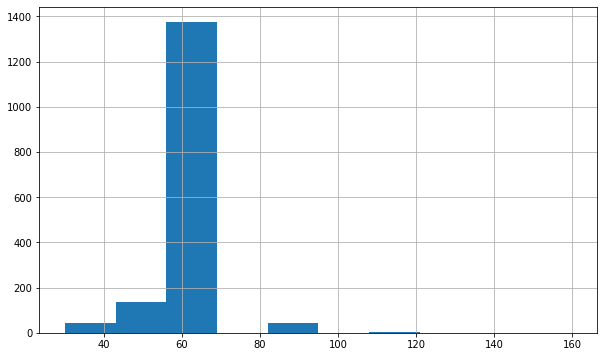

In [49]:
df['lesson_duration'].hist(figsize=(10,6))
None

In [50]:
df['lesson_duration'] = df['lesson_duration'].fillna(round(df['lesson_duration'].mean())) 

### Заполняю пропуски в столбцах, обозначающих стоимость урока

В датасете у меня получилось 6 столбцов, обозначающих стоимость урока. Не очень понимаю какая разница между lesson_cost и price, но на всякий случай оставляю оба столбца. Пропущенные значения в lesson_cost, price и lesson_price_order_mean заполняю из столбца mean_lesson_price. 

In [51]:
df['lesson_cost'] = df['lesson_cost'].fillna(0)
df['lesson_price_order_mean'] = df['lesson_price_order_mean'].fillna(0)

In [52]:
display (df.query('lesson_cost==0')[['lesson_cost', 'mean_lesson_price', 'price', 'price_external', 'price_remote', 'lesson_price_order_mean', 'amount_to_pay_mean']].head(5))

,lesson_cost,mean_lesson_price,price,price_external,price_remote,lesson_price_order_mean,amount_to_pay_mean
7,0.00,1000.00,0.00,0.00,1000.00,779.55,1000.00
19,0.00,2098.09,0.00,2500.00,2500.00,2434.00,1080.21
22,0.00,1000.00,0.00,0.00,1500.00,1097.83,0.00
30,0.00,940.00,0.00,0.00,1500.00,1180.00,700.00
64,0.00,2274.85,2200.00,2200.00,2200.00,2249.45,1390.28


Пишу функцию, которая заполнит пропущенные значения в столбцах, значениями из столбца mean_lesson_price

In [53]:
def lesson_price (row):
    #если значение в столбце равно 0, то функция возвращает значения из столбца mean_lesson_price
    lesson_cost = row['lesson_cost']
    mean_lesson_price = row['mean_lesson_price']
    price = row ['price']
    lesson_price_order_mean = row['lesson_price_order_mean']
    if lesson_cost ==0:
        return mean_lesson_price
    else:
        return lesson_cost
    if price ==0:
        return mean_lesson_price
    else:
        return price
    if lesson_price_order_mean == 0:
        return mean_lesson_price
    else:
        return lesson_price_order_mean

df['lesson_cost'] = df.apply(lesson_price, axis=1)
df['price'] = df.apply(lesson_price, axis=1)
df['mean_lesson_price'] = df.apply(lesson_price, axis=1)
df['amount_to_pay_mean'] = df.apply(lesson_price, axis=1)

In [54]:
display (df.query('price_external==0')[['lesson_cost', 'mean_lesson_price', 'price', 'price_external', 'price_remote', 'lesson_price_order_mean', 'amount_to_pay_mean']].head(5))

,lesson_cost,mean_lesson_price,price,price_external,price_remote,lesson_price_order_mean,amount_to_pay_mean
0,800.00,800.00,800.00,0.00,1700.00,1427.27,800.00
1,600.00,600.00,600.00,0.00,1200.00,1041.86,600.00
2,2500.00,2500.00,2500.00,0.00,2500.00,2651.61,2500.00
4,1178.00,1178.00,1178.00,0.00,1178.00,1525.82,1178.00
6,2200.00,2200.00,2200.00,0.00,2500.00,2388.00,2200.00


### Заполняю пропуски в столбцах is_display, area_id, sex, orders_allowed, review_num

In [55]:
display (df['is_display'].unique())

array([ 1.,  0., nan])

В столбце is_display (показывается в каталоге) три значения: да, нет, не заполнено. Заполняю пропуски нулями

In [56]:
df['is_display'] = df['is_display'].fillna(0)

In [57]:
display (df['area_id'].unique())

array([  2.,  13.,   1., 116.,  20.,  55.,  38.,  21.,  51.,  46.,  14.,
        48.,  35.,   3.,  17.,   5.,  15.,  70.,   6.,  54.,  22.,   9.,
         8.,  33.,  53.,  27.,  49.,  39.,  41.,  11.,  16.,  30.,  18.,
        69.,  12.,  32.,  58.,   4.,   7.,  57.,  24.,  42.,  59.,  19.,
        56.,  31.,  45.,  37.,  nan,  43.,  23.,  10.,  64.,  25.,  40.,
        44.,  50.,  77.,  36.,  91.,  29.,  61.,  52.,  81., 118.,  79.,
        34.])

Нет возможности восстановить пропущенные значения в столбце area_id, поэтому заполняю пропуски нулями

In [58]:
df['area_id'] = df['area_id'].fillna(0)

In [59]:
display (df['sex'].unique())

array([ 1.,  2., nan])

Заполняю пропуски нулями

In [60]:
df['sex'] = df['sex'].fillna(0)

In [61]:
display (df['orders_allowed'].unique())

array([ 1.,  0., nan])

Нет возможности восстановить пропуски в столбце "разрешено назначать на заявки", поэтому заполняю нулями

In [62]:
df['orders_allowed'] = df['orders_allowed'].fillna(0)

In [63]:
display (df['review_num'].unique())

array([ 10.,  26.,  64.,   1.,   0.,  48.,   2.,   4.,  43.,  16.,   6.,
        18.,  33.,   3.,   8.,  11.,  15.,  65.,   5.,  30.,  12.,  20.,
        45.,  35.,   9.,  17.,  31.,  19.,  54.,  23.,  32.,  27.,  38.,
        14.,  66.,  22.,  80.,  88.,  25.,  50.,  79.,  29.,  24.,   7.,
        13.,  36.,  21.,  53.,  58.,  49.,  56.,  44.,  67.,  69.,  51.,
        82.,  34.,  97.,  52.,  40.,  28.,  55., 128.,  61.,  42.,  70.,
        85.,  57.,  37.,  39.,  62., 152.,  41.,  47.,  92., 112.,  nan,
        76.,  83.,  73.,  93., 114.,  75., 117.,  59.,  60.,  96.])

Пропуски в столбце "отзывы", скорее всего, означают, что отзывов нет. Поэтому, заполняю пропуски нулями

In [64]:
df['review_num'] = df['review_num'].fillna(0)

### Заполняю пропуски в столбцах client_id_count, order_id_count, is_active, is_regular

Предполагаю, что пропуски в столбцах client_id_count и order_id_count означают отсутствие учеников и заявок у таких репетиторов. Поэтому, заполняю столбцы нулями

In [65]:
df['client_id_count'] = df['client_id_count'].fillna(0)

In [66]:
df['order_id_count'] = df['order_id_count'].fillna(0)

In [67]:
display (df['is_active'].unique())

array([ 1.,  0., nan])

In [68]:
display (df['is_regular'].unique())

array([ 0.,  1., nan])

Заполняю пропуски в столбцах is_active & is_regular нулями

In [69]:
df['is_active'] = df['is_active'].fillna(0)

In [70]:
df['is_regular'] = df['is_regular'].fillna(0)

### Заполняю пропуски в столбцах subject_id_count, planned_lesson_number_mean, lessons_per_week_mean     

Я предполагаю, что пропуски в столбце subject_id_count означают, что у репетитора не было назначенных уроков. Поэтому, заполняю пропуски в данных столбцах нулями

In [71]:
df['planned_lesson_number_mean'] = df['planned_lesson_number_mean'].fillna(0)

In [72]:
df['lessons_per_week_mean'] = df['lessons_per_week_mean'].fillna(0)

### Вывод по разделу "Обработка пропусков"

Я завершила обработку пропусков. Проверяю, что все пропуски заполнены. 

In [73]:
print (df.isna().sum())

teacher_id                    0
reg_date                      0
birth_date                    0
teaching_start_date           0
is_email_confirmed            0
lesson_duration               0
lesson_cost                   0
is_display                    0
last_visited                  0
is_cell_phone_confirmed       0
area_id                       0
sex                           0
orders_allowed                0
review_num                    0
lessons_delivered             0
mean_lesson_price             0
lessons_given                 0
lessons_started_fraction      0
lessons_per_pupil             0
money_recieved                0
blocked                       0
subject_id                    0
price                         0
price_external                0
price_remote                  0
client_id_count               0
order_id_count                0
is_active                     0
is_regular                    0
amount_to_pay_mean            0
lesson_price_order_mean       0
planned_

# Анализ данных в сводной таблице

### Вывожу графики распределения данных в сводной таблице

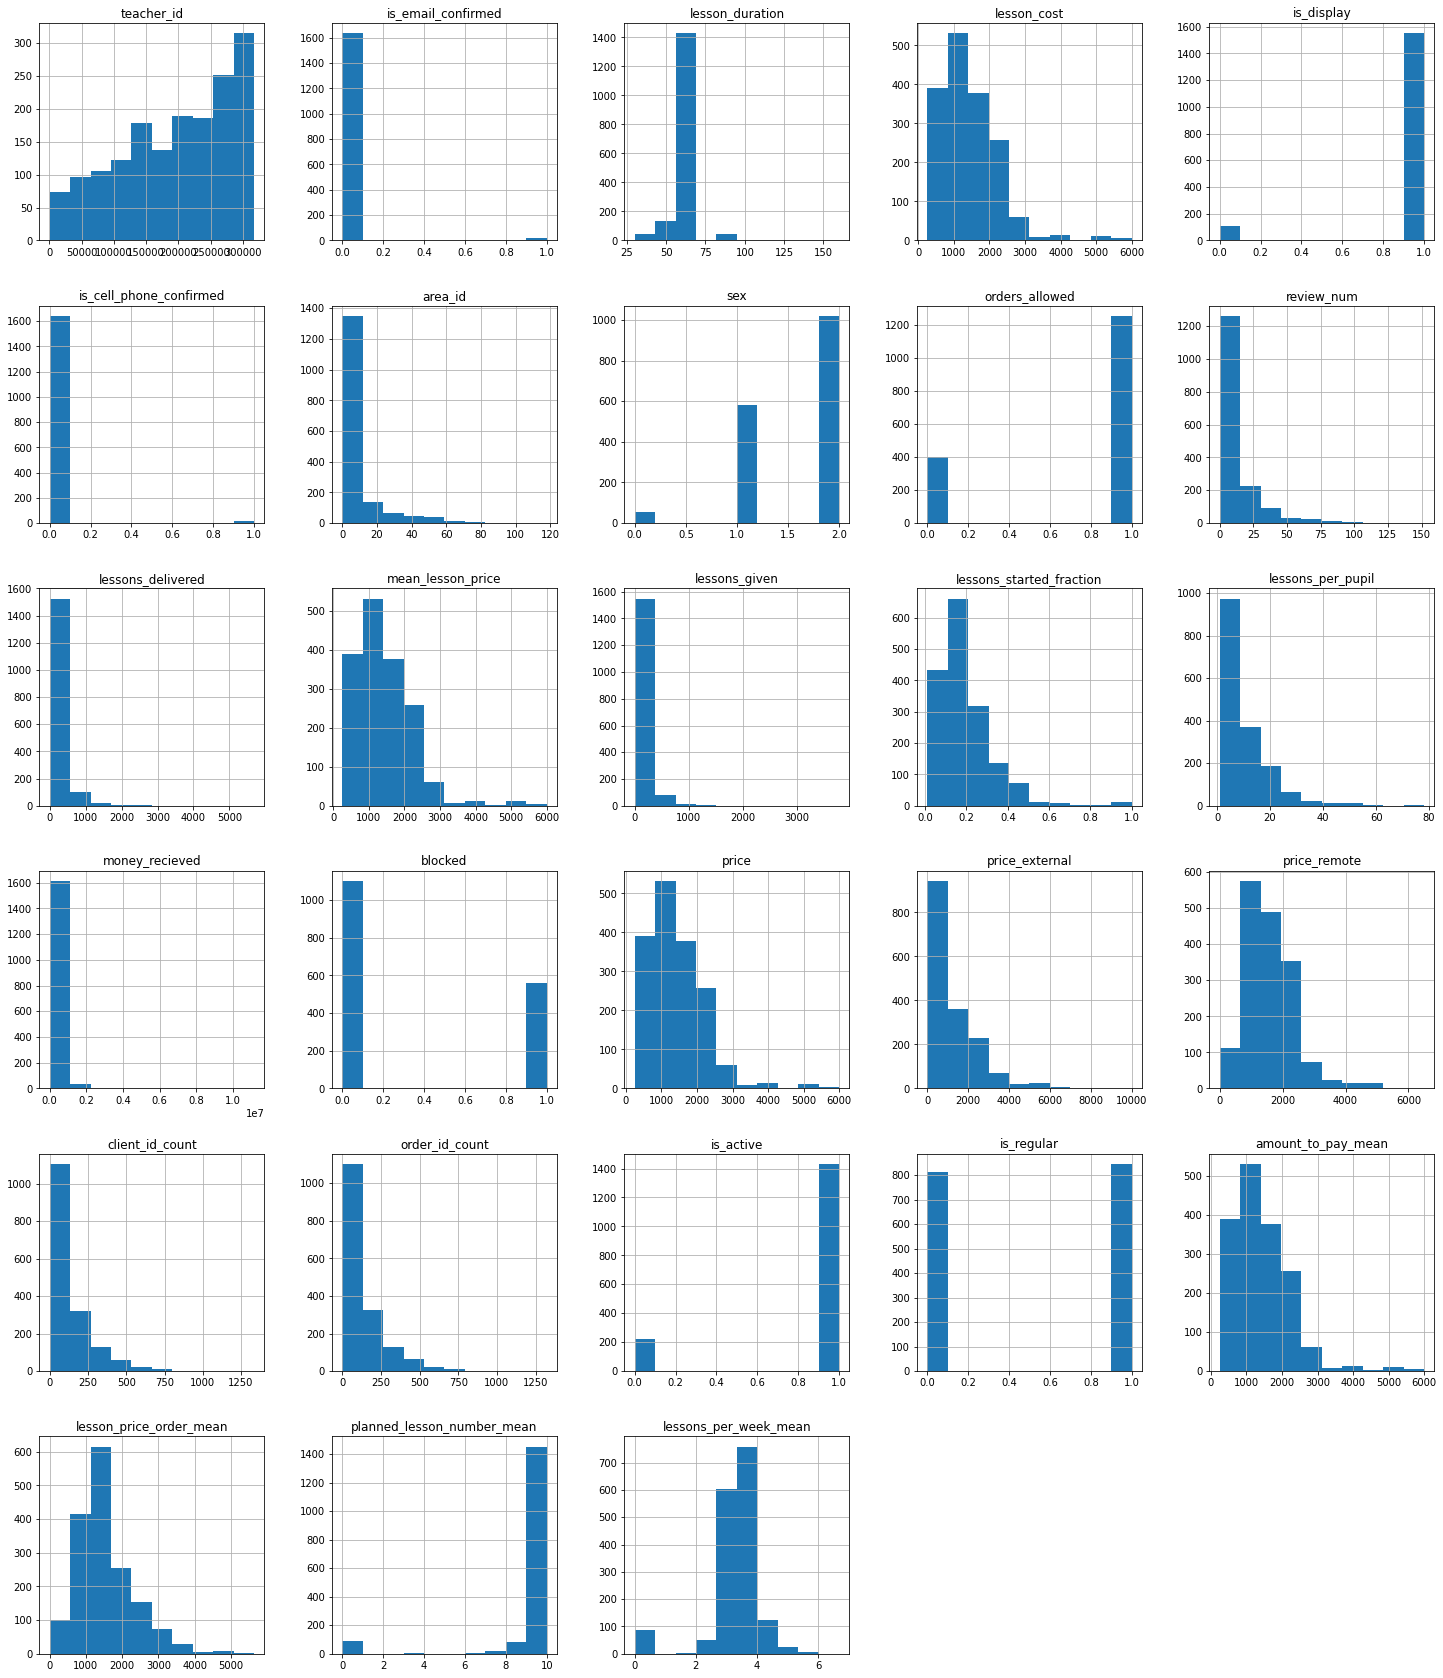

In [74]:
df.hist(figsize=(25,30))
None

### Изучаю подробнее столбец lessons_delivered (поставлено уроков)

Странно выглядят сверх большие значения в столбце lessons_delivered (больше 4000 уроков). Изучаю этот столбец подробнее

In [75]:
display (df.query('lessons_delivered>4000'))

,teacher_id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,subject_id,price,price_external,price_remote,client_id_count,order_id_count,is_active,is_regular,amount_to_pay_mean,lesson_price_order_mean,planned_lesson_number_mean,lessons_per_week_mean
248,139229,2018-02-23 14:42:59.000,1967-03-06 00:00:00.000,1989-09-01 00:00:00.000,0.00,60.00,3500.00,1.00,2022-10-24 11:13:09.607,0.00,1.00,2.00,1.00,67.00,5690.00,3500.00,3788.00,0.40,18.12,11162200.00,0,"[17, 2, 8, 1, 14, 5]",3500.00,3583.33,3583.33,1336.00,1322.00,1.00,1.00,3500.00,3872.72,9.38,4.08


Я сначала подумала, что такие значения - это ошибка. Но судя по тому сколько денег поступило от конкретного репетитора - это не ошибка. Возможно, репетитор работает не один или берет детей в групповую работу. Оставляю значения в этом столбце как есть

### Промежуточный вывод по разделу

У большинства преподавателей не доступен е-мейл и номер телефона.\
Продолжительность урока варьируется от 25 до 150 минут.\
Стоимость урока составляет от примерно 300 руб до 6000 рублей за урок.\
Количество уроков на 1 ученика от 0 до 80 уроков.\
Запланированное количество уроков составляет от 0 до 10 уроков.

# Генерирую дополнительные признаки

Я думаю, что можно дополнительно сгенерировать следующие признаки:\
- возраст репетитора
- преподавательский стаж
- сколько дней назад репетитор заходил на сервис

### Перевожу признаки, обозначающие даты, в формат datetime

In [76]:
df['reg_date'] = pd.to_datetime(df['reg_date'], format='%Y-%m-%d %H:%M')

In [77]:
df['birth_date'] = pd.to_datetime(df['birth_date'], format='%Y-%m-%d %H:%M')

In [78]:
df['teaching_start_date'] = pd.to_datetime(df['teaching_start_date'], format='%Y-%m-%d %H:%M')

In [79]:
df['last_visited'] = pd.to_datetime(df['last_visited'], format='%Y-%m-%d %H:%M')

### Создаю признак: возраст репетитора (teacher_age)

In [80]:
current_date = datetime.now()
df['teacher_age'] = current_date.year - df['birth_date'].dt.year

In [81]:
display (df[['teacher_age', 'birth_date']].head(5))

,teacher_age,birth_date
0,27,1997-04-16
1,56,1968-03-10
2,59,1965-04-20
3,38,1986-05-07
4,51,1973-09-14


### Создаю признак: преподавательский стаж teacher_experience

In [82]:
df['teacher_experience'] = current_date.year - df['teaching_start_date'].dt.year

In [83]:
display (df[['teacher_experience', 'teaching_start_date']].head(5))

,teacher_experience,teaching_start_date
0,7,2017-09-01
1,39,1985-09-01
2,22,2002-09-01
3,19,2005-09-01
4,32,1992-09-01


### Создаю признак: сколько дней назад преподаватель заходил на сервис last_visited_days

In [84]:
df['last_visited_days'] = datetime.now() - df['last_visited']

In [85]:
df['last_visited_days'] = df['last_visited_days'].dt.days

In [86]:
display (df[['last_visited_days', 'last_visited']].head(5))

,last_visited_days,last_visited
0,528,2022-10-21 16:44:49.877
1,527,2022-10-22 16:16:44.800
2,527,2022-10-22 21:21:47.523
3,746,2022-03-17 22:50:23.267
4,19815,1970-01-01 00:00:00.000


# Подготовка данных для обучения

### Исследование дисбаланса классов

0   0.66
1   0.34
Name: blocked, dtype: float64


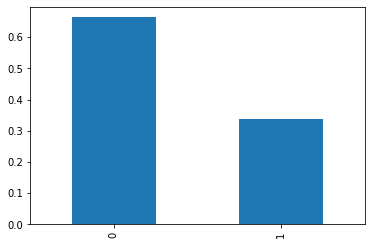

In [87]:
class_frequency = df['blocked'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
None

Выявлен дисбаланс классов. Единиц примено вдвое меньше, чем нулей.

### Разбиваю данные на выборки

In [88]:
features = df.drop(['teacher_id', 'reg_date', 'birth_date', 'teaching_start_date', 'blocked', 'subject_id', 'last_visited', 'area_id'], axis=1)
target = df['blocked']

features_train, features_test, target_train, target_test = train_test_split(features, \
                                                                            target, \
                                                                            test_size=0.25, \
                                                                            random_state=123456, \
                                                                           stratify=target) #делю данные 65-25%

print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [824 418]
Количество строк в target_test по классам: [275 139]


In [89]:
display (features_train.head(5))

,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_cell_phone_confirmed,sex,orders_allowed,review_num,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,price,price_external,price_remote,client_id_count,order_id_count,is_active,is_regular,amount_to_pay_mean,lesson_price_order_mean,planned_lesson_number_mean,lessons_per_week_mean,teacher_age,teacher_experience,last_visited_days
1484,0.00,60.00,1200.00,1.00,0.00,1.00,0.00,14.00,28.00,1200.00,15.00,0.07,1.36,18000.00,1200.00,1500.00,1500.00,286.00,286.00,1.00,1.00,1200.00,1104.21,8.67,3.39,28,5,526
389,0.00,60.00,2500.00,1.00,0.00,2.00,1.00,2.00,30.00,2500.00,28.00,0.12,14.00,75000.00,2500.00,4500.00,3000.00,29.00,29.00,0.00,0.00,2500.00,3285.71,10.00,4.07,47,25,546
374,0.00,60.00,4000.00,1.00,0.00,1.00,1.00,2.00,155.00,4000.00,43.00,0.08,14.33,48900.00,4000.00,4000.00,1500.00,38.00,38.00,1.00,0.00,4000.00,1662.86,9.91,3.60,24,5,535
511,0.00,60.00,1200.00,1.00,0.00,2.00,1.00,0.00,164.00,1200.00,46.00,0.07,11.50,82650.00,1200.00,0.00,1400.00,57.00,57.00,1.00,1.00,1200.00,1549.12,9.65,3.07,67,32,19815
283,0.00,60.00,1500.00,1.00,0.00,2.00,0.00,9.00,55.00,1500.00,17.00,0.33,17.00,21250.00,1500.00,1500.00,1500.00,89.00,89.00,1.00,1.00,1500.00,1506.49,9.75,3.92,26,7,532


### Масштабирую количественные данные

In [90]:
numeric = ['lesson_duration', 'lesson_cost', 'review_num', 'lessons_delivered', 'mean_lesson_price', 'lessons_given', 'lessons_started_fraction', 'lessons_per_pupil',\
          'money_recieved', 'price', 'price_external', 'price_remote', 'client_id_count', 'order_id_count', 'amount_to_pay_mean', 'lesson_price_order_mean',\
          'planned_lesson_number_mean', 'lessons_per_week_mean', 'teacher_age', 'teacher_experience', 'last_visited_days']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
display (features_train.head(5))
display (features_test.head(5))

(1242, 28)


,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_cell_phone_confirmed,sex,orders_allowed,review_num,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,price,price_external,price_remote,client_id_count,order_id_count,is_active,is_regular,amount_to_pay_mean,lesson_price_order_mean,planned_lesson_number_mean,lessons_per_week_mean,teacher_age,teacher_experience,last_visited_days
1484,0.00,0.11,-0.25,1.00,0.00,1.00,0.00,0.17,-0.49,-0.25,-0.46,-0.97,-0.89,-0.39,-0.25,0.44,-0.08,1.11,1.12,1.00,1.00,-0.25,-0.54,-0.22,0.11,-0.56,-0.75,-0.57
389,0.00,0.11,1.39,1.00,0.00,2.00,1.00,-0.54,-0.49,1.39,-0.39,-0.53,0.39,-0.25,1.39,2.85,1.76,-0.67,-0.67,0.00,0.00,1.39,2.18,0.36,0.86,1.11,1.06,-0.57
374,0.00,0.11,3.29,1.00,0.00,1.00,1.00,-0.54,-0.08,3.29,-0.32,-0.84,0.42,-0.32,3.29,2.45,-0.08,-0.61,-0.60,1.00,0.00,3.29,0.16,0.32,0.34,-0.91,-0.75,-0.57
511,0.00,0.11,-0.25,1.00,0.00,2.00,1.00,-0.66,-0.05,-0.25,-0.30,-0.92,0.14,-0.23,-0.25,-0.76,-0.20,-0.47,-0.47,1.00,1.00,-0.25,0.02,0.20,-0.23,2.86,1.69,1.77
283,0.00,0.11,0.13,1.00,0.00,2.00,0.00,-0.12,-0.41,0.13,-0.45,1.00,0.69,-0.38,0.13,0.44,-0.08,-0.25,-0.25,1.00,1.00,0.13,-0.04,0.25,0.69,-0.73,-0.57,-0.57


,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_cell_phone_confirmed,sex,orders_allowed,review_num,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,price,price_external,price_remote,client_id_count,order_id_count,is_active,is_regular,amount_to_pay_mean,lesson_price_order_mean,planned_lesson_number_mean,lessons_per_week_mean,teacher_age,teacher_experience,last_visited_days
912,0.00,-1.65,0.50,1.00,0.00,2.00,1.00,-0.54,-0.54,0.50,-0.48,-0.40,-0.42,-0.39,0.50,0.68,-0.08,-0.47,-0.47,1.00,0.00,0.50,0.62,0.31,0.63,0.84,-0.11,1.77
23,0.00,0.11,-0.25,1.00,0.00,2.00,1.00,-0.48,1.64,-0.25,1.64,2.22,3.33,1.06,-0.25,0.84,0.53,-0.56,-0.56,1.00,1.00,-0.25,0.37,0.36,0.08,-0.03,-0.39,-0.57
1453,0.00,0.11,1.89,1.00,0.00,2.00,1.00,-0.30,-0.57,1.89,-0.52,2.22,-0.87,-0.42,1.89,-0.76,0.84,-0.77,-0.76,0.00,0.00,1.89,0.29,-0.96,0.34,0.14,0.16,-0.57
1434,0.00,0.11,-1.01,1.00,0.00,2.00,1.00,-0.24,-0.56,-1.01,-0.50,-0.73,-0.85,-0.42,-1.01,-0.76,-0.69,-0.21,-0.21,1.00,1.00,-1.01,-0.85,0.31,0.14,0.58,0.88,-0.57
177,0.00,0.11,-0.19,1.00,0.00,2.00,1.00,-0.66,-0.44,-0.19,-0.32,-0.68,1.14,-0.30,-0.19,-0.76,-0.33,-0.79,-0.79,1.00,0.00,-0.19,-0.23,0.36,-0.31,-1.26,-0.93,1.77


### Кодирую категориальные значения

In [91]:
categories = ['is_email_confirmed', 'is_display', 'is_cell_phone_confirmed', 'sex', 'orders_allowed', 'is_active', 'is_regular']
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='error', drop='first')

result_train_ohe = onehot_encoder.fit_transform(features_train[categories])
result_train = pd.DataFrame(result_train_ohe, columns=onehot_encoder.get_feature_names_out(categories),\
                                                                        index=features_train.index)
features_train_ohe = result_train.join(features_train[numeric])
features_train_ohe.head()

,is_email_confirmed_1.0,is_display_1.0,is_cell_phone_confirmed_1.0,sex_1.0,sex_2.0,orders_allowed_1.0,is_active_1.0,is_regular_1.0,lesson_duration,lesson_cost,review_num,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,price,price_external,price_remote,client_id_count,order_id_count,amount_to_pay_mean,lesson_price_order_mean,planned_lesson_number_mean,lessons_per_week_mean,teacher_age,teacher_experience,last_visited_days
1484,0.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.11,-0.25,0.17,-0.49,-0.25,-0.46,-0.97,-0.89,-0.39,-0.25,0.44,-0.08,1.11,1.12,-0.25,-0.54,-0.22,0.11,-0.56,-0.75,-0.57
389,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.11,1.39,-0.54,-0.49,1.39,-0.39,-0.53,0.39,-0.25,1.39,2.85,1.76,-0.67,-0.67,1.39,2.18,0.36,0.86,1.11,1.06,-0.57
374,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,0.11,3.29,-0.54,-0.08,3.29,-0.32,-0.84,0.42,-0.32,3.29,2.45,-0.08,-0.61,-0.60,3.29,0.16,0.32,0.34,-0.91,-0.75,-0.57
511,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,0.11,-0.25,-0.66,-0.05,-0.25,-0.30,-0.92,0.14,-0.23,-0.25,-0.76,-0.20,-0.47,-0.47,-0.25,0.02,0.20,-0.23,2.86,1.69,1.77
283,0.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,0.11,0.13,-0.12,-0.41,0.13,-0.45,1.00,0.69,-0.38,0.13,0.44,-0.08,-0.25,-0.25,0.13,-0.04,0.25,0.69,-0.73,-0.57,-0.57


In [92]:
result_test_ohe = onehot_encoder.transform(features_test[categories])
result_test = pd.DataFrame(result_test_ohe, columns=onehot_encoder.get_feature_names_out(categories),\
                                                                        index=features_test.index)
features_test_ohe = result_test.join(features_test[numeric])
features_test_ohe.head()

,is_email_confirmed_1.0,is_display_1.0,is_cell_phone_confirmed_1.0,sex_1.0,sex_2.0,orders_allowed_1.0,is_active_1.0,is_regular_1.0,lesson_duration,lesson_cost,review_num,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,price,price_external,price_remote,client_id_count,order_id_count,amount_to_pay_mean,lesson_price_order_mean,planned_lesson_number_mean,lessons_per_week_mean,teacher_age,teacher_experience,last_visited_days
912,0.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,-1.65,0.50,-0.54,-0.54,0.50,-0.48,-0.40,-0.42,-0.39,0.50,0.68,-0.08,-0.47,-0.47,0.50,0.62,0.31,0.63,0.84,-0.11,1.77
23,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,0.11,-0.25,-0.48,1.64,-0.25,1.64,2.22,3.33,1.06,-0.25,0.84,0.53,-0.56,-0.56,-0.25,0.37,0.36,0.08,-0.03,-0.39,-0.57
1453,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.11,1.89,-0.30,-0.57,1.89,-0.52,2.22,-0.87,-0.42,1.89,-0.76,0.84,-0.77,-0.76,1.89,0.29,-0.96,0.34,0.14,0.16,-0.57
1434,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,0.11,-1.01,-0.24,-0.56,-1.01,-0.50,-0.73,-0.85,-0.42,-1.01,-0.76,-0.69,-0.21,-0.21,-1.01,-0.85,0.31,0.14,0.58,0.88,-0.57
177,0.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.11,-0.19,-0.66,-0.44,-0.19,-0.32,-0.68,1.14,-0.30,-0.19,-0.76,-0.33,-0.79,-0.79,-0.19,-0.23,0.36,-0.31,-1.26,-0.93,1.77


### Для исследования моделей, основанных на деревьях решений, использую порядковое кодирование

In [93]:
# порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['is_email_confirmed', 'is_display', 'is_cell_phone_confirmed', 'sex', 'orders_allowed', 'is_active', 'is_regular']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

### Масштабирую признаки столбцов

In [94]:
numeric = ['lesson_duration', 'lesson_cost', 'review_num', 'lessons_delivered', 'mean_lesson_price', 'lessons_given', 'lessons_started_fraction', 'lessons_per_pupil',\
          'money_recieved', 'price', 'price_external', 'price_remote', 'client_id_count', 'order_id_count', 'amount_to_pay_mean', 'lesson_price_order_mean',\
          'planned_lesson_number_mean', 'lessons_per_week_mean', 'teacher_age', 'teacher_experience', 'last_visited_days']

scaler = StandardScaler()
scaler.fit(features_train_ord[numeric])
features_train_ord[numeric] = scaler.transform(features_train_ord[numeric])
features_test_ord[numeric] = scaler.transform(features_test_ord[numeric])

print(features_train_ord.shape)
display (features_train_ord.head(5))
display (features_test_ord.head(5))

(1242, 28)


,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_cell_phone_confirmed,sex,orders_allowed,review_num,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,price,price_external,price_remote,client_id_count,order_id_count,is_active,is_regular,amount_to_pay_mean,lesson_price_order_mean,planned_lesson_number_mean,lessons_per_week_mean,teacher_age,teacher_experience,last_visited_days
1484,0.00,0.11,-0.25,1.00,0.00,1.00,0.00,0.17,-0.49,-0.25,-0.46,-0.97,-0.89,-0.39,-0.25,0.44,-0.08,1.11,1.12,1.00,1.00,-0.25,-0.54,-0.22,0.11,-0.56,-0.75,-0.57
389,0.00,0.11,1.39,1.00,0.00,2.00,1.00,-0.54,-0.49,1.39,-0.39,-0.53,0.39,-0.25,1.39,2.85,1.76,-0.67,-0.67,0.00,0.00,1.39,2.18,0.36,0.86,1.11,1.06,-0.57
374,0.00,0.11,3.29,1.00,0.00,1.00,1.00,-0.54,-0.08,3.29,-0.32,-0.84,0.42,-0.32,3.29,2.45,-0.08,-0.61,-0.60,1.00,0.00,3.29,0.16,0.32,0.34,-0.91,-0.75,-0.57
511,0.00,0.11,-0.25,1.00,0.00,2.00,1.00,-0.66,-0.05,-0.25,-0.30,-0.92,0.14,-0.23,-0.25,-0.76,-0.20,-0.47,-0.47,1.00,1.00,-0.25,0.02,0.20,-0.23,2.86,1.69,1.77
283,0.00,0.11,0.13,1.00,0.00,2.00,0.00,-0.12,-0.41,0.13,-0.45,1.00,0.69,-0.38,0.13,0.44,-0.08,-0.25,-0.25,1.00,1.00,0.13,-0.04,0.25,0.69,-0.73,-0.57,-0.57


,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_cell_phone_confirmed,sex,orders_allowed,review_num,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,price,price_external,price_remote,client_id_count,order_id_count,is_active,is_regular,amount_to_pay_mean,lesson_price_order_mean,planned_lesson_number_mean,lessons_per_week_mean,teacher_age,teacher_experience,last_visited_days
912,0.00,-1.65,0.50,1.00,0.00,2.00,1.00,-0.54,-0.54,0.50,-0.48,-0.40,-0.42,-0.39,0.50,0.68,-0.08,-0.47,-0.47,1.00,0.00,0.50,0.62,0.31,0.63,0.84,-0.11,1.77
23,0.00,0.11,-0.25,1.00,0.00,2.00,1.00,-0.48,1.64,-0.25,1.64,2.22,3.33,1.06,-0.25,0.84,0.53,-0.56,-0.56,1.00,1.00,-0.25,0.37,0.36,0.08,-0.03,-0.39,-0.57
1453,0.00,0.11,1.89,1.00,0.00,2.00,1.00,-0.30,-0.57,1.89,-0.52,2.22,-0.87,-0.42,1.89,-0.76,0.84,-0.77,-0.76,0.00,0.00,1.89,0.29,-0.96,0.34,0.14,0.16,-0.57
1434,0.00,0.11,-1.01,1.00,0.00,2.00,1.00,-0.24,-0.56,-1.01,-0.50,-0.73,-0.85,-0.42,-1.01,-0.76,-0.69,-0.21,-0.21,1.00,1.00,-1.01,-0.85,0.31,0.14,0.58,0.88,-0.57
177,0.00,0.11,-0.19,1.00,0.00,2.00,1.00,-0.66,-0.44,-0.19,-0.32,-0.68,1.14,-0.30,-0.19,-0.76,-0.33,-0.79,-0.79,1.00,0.00,-0.19,-0.23,0.36,-0.31,-1.26,-0.93,1.77


# Исследую модели

### Исследую модель случайного леса. Гиперпараметры подбираю через GridSearch

In [95]:
kf = StratifiedKFold(n_splits=5)

In [96]:
%%time

clf = RandomForestClassifier (random_state=123456) #объявляем классификатор

param = { 'n_estimators': range(50, 200, 150), 'max_depth': [i for i in range(2, 25)] } #задаем параметры классификатора

grid = GridSearchCV(estimator = clf,
                    param_grid = param,
                    cv = kf,
                    n_jobs = -1,
                    verbose = 0,
                    scoring = 'f1') #запускаем обучение
grid.fit(features_train_ord, target_train)

print ('F1 наилучшей модели', grid.best_score_) #выводим наилучшую метрику
print ('Какие гиперпараметры дали наилучший результат', grid.best_params_) #выводим наилучшие параметры модели

F1 наилучшей модели 0.62680753340639
Какие гиперпараметры дали наилучший результат {'max_depth': 16, 'n_estimators': 50}
Wall time: 6.81 s


### Исследую модель LightGBM

In [97]:
%%time

clf = lgb.LGBMClassifier (boosting_type='gbdt',  objective='binary', \
                          learning_rate=0.02, metric='f1', random_state=123456) #объявляем классификатор

param = { 'n_estimators': range(50, 200, 150), 'max_depth': [i for i in range(3, 12)]} #задаем параметры классификатора

grid = GridSearchCV(estimator = clf,
                    param_grid = param,
                    cv = kf,
                    n_jobs = -1,
                    verbose = 0,
                    scoring='f1') #запускаем обучение
grid.fit(features_train_ohe, target_train)

print ('F1 наилучшей модели', grid.best_score_) #выводим наилучшую метрику
print ('Какие гиперпараметры дали наилучший результат', grid.best_params_) #выводим наилучшие параметры модели

F1 наилучшей модели 0.603700599046432
Какие гиперпараметры дали наилучший результат {'max_depth': 9, 'n_estimators': 50}
Wall time: 725 ms


### Исследую модель CatBoost

%%time

clf = CatBoostClassifier (random_state=123456) #объявляем классификатор

param = {'max_depth': [i for i in range(6, 12)],
                  'learning_rate':[0.01, 0.1],
                  'iterations': [400, 500]}  #задаем параметры классификатор


grid = GridSearchCV(estimator = clf,
                    param_grid = param,
                    cv = kf, #записываю сюда параметры стратификатора kf
                    n_jobs = -1,
                    verbose = 0,
                    scoring = 'f1') #запускаем обучение
grid.fit(features_train_ohe, target_train)
print(grid.best_params_)
grid.best_score_

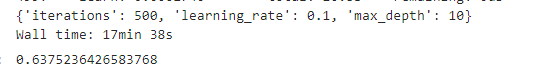

### Исследую модель CatBoost - убираю часть признаков

Убираю часть признаков (которые не сильно влияют на результат работы модели) и проверю как изменится метрика

In [103]:
features_train_ohe_drop = features_train_ohe.drop(['amount_to_pay_mean', 'lesson_cost', 'mean_lesson_price', 'lesson_price_order_mean'], axis=1)

In [104]:
%%time

clf = CatBoostClassifier (random_state=123456) #объявляем классификатор

param = {'max_depth': [i for i in range(6, 12)],
                  'learning_rate':[0.01, 0.1],
                  'iterations': [400, 500]}  #задаем параметры классификатор


grid = GridSearchCV(estimator = clf,
                    param_grid = param,
                    cv = kf, #записываю сюда параметры стратификатора kf
                    n_jobs = -1,
                    verbose = 0,
                    scoring = 'f1') #запускаем обучение
grid.fit(features_train_ohe_drop, target_train)
print(grid.best_params_)
grid.best_score_

0:	learn: 0.6381524	total: 18.5ms	remaining: 9.25s
1:	learn: 0.6020912	total: 32.8ms	remaining: 8.16s
2:	learn: 0.5612884	total: 45.9ms	remaining: 7.61s
3:	learn: 0.5372238	total: 58.6ms	remaining: 7.26s
4:	learn: 0.5102147	total: 70.7ms	remaining: 7s
5:	learn: 0.4867145	total: 82.9ms	remaining: 6.82s
6:	learn: 0.4656313	total: 95.5ms	remaining: 6.72s
7:	learn: 0.4451245	total: 110ms	remaining: 6.74s
8:	learn: 0.4289883	total: 122ms	remaining: 6.67s
9:	learn: 0.4148097	total: 135ms	remaining: 6.63s
10:	learn: 0.4032258	total: 149ms	remaining: 6.63s
11:	learn: 0.3953118	total: 163ms	remaining: 6.62s
12:	learn: 0.3857903	total: 176ms	remaining: 6.58s
13:	learn: 0.3729943	total: 188ms	remaining: 6.53s
14:	learn: 0.3622087	total: 202ms	remaining: 6.52s
15:	learn: 0.3477574	total: 216ms	remaining: 6.54s
16:	learn: 0.3408946	total: 228ms	remaining: 6.49s
17:	learn: 0.3349571	total: 241ms	remaining: 6.46s
18:	learn: 0.3261144	total: 256ms	remaining: 6.47s
19:	learn: 0.3179047	total: 269ms	rem

0.6486996052974248

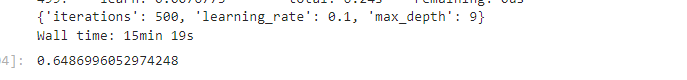

# Тестирование модели

Наилучший результат показала модель CatBoost (F1=0,65). Тестирую эту модель

Также убираю часть признаков из тествой выборки

In [109]:
features_test_ohe_drop = features_test_ohe.drop(['amount_to_pay_mean', 'lesson_cost', 'mean_lesson_price', 'lesson_price_order_mean'], axis=1)

In [110]:
best_model = CatBoostClassifier(random_state=123456,
                           iterations = 500,
                           learning_rate = 0.1,
                           max_depth = 9).fit(features_train_ohe_drop, target_train)

0:	learn: 0.6381524	total: 15.7ms	remaining: 7.84s
1:	learn: 0.6020912	total: 29.9ms	remaining: 7.44s
2:	learn: 0.5612884	total: 43.7ms	remaining: 7.24s
3:	learn: 0.5372238	total: 57.2ms	remaining: 7.09s
4:	learn: 0.5102147	total: 70.3ms	remaining: 6.96s
5:	learn: 0.4867145	total: 82.6ms	remaining: 6.8s
6:	learn: 0.4656313	total: 94ms	remaining: 6.62s
7:	learn: 0.4451245	total: 105ms	remaining: 6.46s
8:	learn: 0.4289883	total: 117ms	remaining: 6.38s
9:	learn: 0.4148097	total: 129ms	remaining: 6.31s
10:	learn: 0.4032258	total: 140ms	remaining: 6.24s
11:	learn: 0.3953118	total: 151ms	remaining: 6.15s
12:	learn: 0.3857903	total: 162ms	remaining: 6.08s
13:	learn: 0.3729943	total: 173ms	remaining: 6.02s
14:	learn: 0.3622087	total: 184ms	remaining: 5.96s
15:	learn: 0.3477574	total: 196ms	remaining: 5.92s
16:	learn: 0.3408946	total: 208ms	remaining: 5.91s
17:	learn: 0.3349571	total: 220ms	remaining: 5.89s
18:	learn: 0.3261144	total: 233ms	remaining: 5.9s
19:	learn: 0.3179047	total: 246ms	rema

In [111]:
predictions = best_model.predict(features_test_ohe_drop)
f1 = f1_score(target_test, predictions)

print('F1 на тестовой выборке:', round(f1, 4))

F1 на тестовой выборке: 0.6569


### Исследую важность признаков у лучшей модели

<AxesSubplot:>

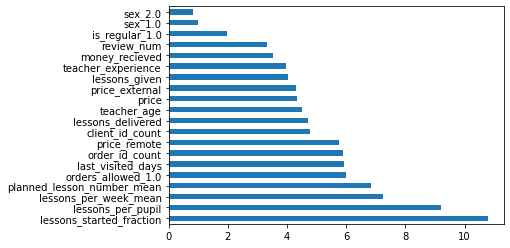

In [112]:
feat_importances = pd.Series(best_model.feature_importances_, index=features_test_ohe_drop.columns)
feat_importances.nlargest(20).plot(kind='barh')

Топ-5 самых важных признаков:\
- lessons_started_fraction
- lessons_per_pupil
- lessons_per_week_mean
- planned_lesson_number_mean
- orders_allowed

# Вывод

Сервис Repetit.ru передает контакты клиента (ученика) репетитору. Если репетитор начинает заниматься с учеником, то он должен платить сервису комиссию от каждого занятия. Но в реальности так происходит не всегда. Иногда, это из-за того, что репетитор звонит по телефону и ему просто не отвечают. Некоторые репетиторы плохо договариваются о занятиях или обманывают. Сервис теряет деньги каждый раз, когда отдаёт заявку неэффективному репетитору. Заказчику нужно как можно раньше понять, что репетитор недобросовестный или мошенник, чтобы отключить его от сервиса и отдавать заявки ответственным репетиторам.\
\
Сейчас эта задача решается ручным просмотром сотрудниками или никак.\
\
**Задачей данного проекта было**\
разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий будет классифицировать репетиторов на платящих и неэффективных. Оценка качества модели будет производиться с использованием метрики F1.\
\
В процессе работы над проектом, я выяснила, что:\
У большинства преподавателей не доступен е-мейл и номер телефона.
Продолжительность урока варьируется от 25 до 150 минут.
Стоимость урока составляет от примерно 300 руб до 6000 рублей за урок.
Количество уроков на 1 ученика от 0 до 80 уроков.
Запланированное количество уроков составляет от 0 до 10 уроков.\
\
\
Для достижения цели проекта, я исследовала три модели: модель случайного леса, LightGBM и CatBoost.\
\
Наилучший результат показала модель CatBoost (F1=0,65)\
Я протестировала данную модель. На тестовой выборке модель также показала результат F1=0,65\
\
\
Наиболее важными признаками у лучшей модели оказались следующие признаки.\
\
**Топ-5 самых важных признаков**\
- lessons_started_fraction
- lessons_per_pupil
- lessons_per_week_mean
- planned_lesson_number_mean
- orders_allowed